# Machine Learning on fingerprints and descriptors - Implementation of the final model

Here we implement the best model find in running our search_model in run_search_model.py 

the final pipeline is defined by the following steps:

* **Univariate Imputer:** Completes missing values with a constant value using `sklearn.impute.SimpleImputer()`.

* **Feature Selector:** Removes all low-variance features using `sklearn.feature_selection.VarianceThreshold()`.

* **Standardization:** Standardizes the dataset with a scaler that removes the median and scales the data according to the quantile range. This utilizes `sklearn.preprocessing.RobustScaler()` for robust scaling.

* **Feature Extraction:** Utilizes recursive feature elimination (RFE) to select features by recursively considering smaller and smaller sets. It is based on weights assigned to each feature calculated by a linear model. Using RFE in the context of biology models is common and often recommended in the literature . We used here a Support Vector Regressor (SVR) as the model for assigning weights. Our hyperparameterization of RFE leads to the selection of 300 features and implementation was done using `sklearn.feature_selection.RFE`.

* **Random Forest for Regression:** The final step implements a random forest for regression with hyperparameters optimized by our global model. The configuration includes 300 trees in the forest, a maximum depth of 20 for each tree, a minimum of 2 samples required to split an internal node, a minimum of 1 sample required to be at a leaf node, \(\log_2(\text{{number of features}}) \approx 8\) features considered for the best split, no use of bootstrap samples when building trees, and the reuse of the solution from the previous call to fit with adding more estimators to the ensemble. We used the function `sklearn.ensemble.RandomForestRegressor` to implement it.


In [5]:
! pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 7.2 MB/s eta 0:00:0000:010:01m1m╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/10.0 MB 18.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 12.7 MB/s eta 0:00:00:00:010:01m��━━━╸ 76.0/76.0 MB 120.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 27.6 MB/s eta 0:00:0000:01:00:01


In [6]:
# Linear algebra and data handling
import numpy as np
import pandas as pd

# Machine learning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, median_absolute_error, classification_report
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.svm import SVR
from sklearn.preprocessing import (StandardScaler, Normalizer, RobustScaler,
                                    MaxAbsScaler)

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

#Extension to speed calculation (X10-100)
from sklearnex import patch_sklearn
patch_sklearn() 


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Load datasets after splitting them

In [6]:
x_train = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/data_fot_ML/final_train_train.csv')
y_train = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/data_fot_ML/Y_train.csv')['y']
x_test = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/data_fot_ML/final_train_test.csv')
y_test = pd.read_csv('/home/onyxia/work/aml_project/data/raw_data/data_fot_ML/Y_test.csv')['y']


Normalization with RobustScaler

In [7]:
transformer = RobustScaler().fit(x_train)
x_train_scaled=transformer.transform(x_train)
x_test_scaled=transformer.transform(x_test)

Feature Extraction with recursive feature elimination (RFE) method

In [4]:
from sklearnex import patch_sklearn
patch_sklearn() 

estimator = SVR(kernel="linear")
print('svr')
selector = RFE(estimator, n_features_to_select=300, step=10)
print('RFE')
selector = selector.fit(x_train_scaled, y_train)
print('fit')

X_train_selected = selector.transform(x_train_scaled)
print('train transform')
X_test_selected = selector.transform(x_test_scaled)
print('test transform')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


svr
RFE


Random Forest for regression

In [22]:
regr = RandomForestRegressor(n_estimators = 100, 
                             max_depth = 20,
                             min_samples_split=2, 
                             min_samples_leaf= 1, 
                             warm_start = True, 
                             bootstrap = False,
                             max_features='log2',
                             n_jobs=-1)
regr.fit(X_train_selected, y_train)
y_train_predict= regr.predict(X_train_selected)
y_test_predict= regr.predict(X_test_selected)

In [20]:
                             
bagging_model = BaggingRegressor(base_estimator=regr, random_state=0, verbose=False,
                                 max_samples=.9, bootstrap=False, n_estimators=25)
bagging_model.fit(X_train_selected, y_train)
y_train_predict= bagging_model.predict(X_train_selected)
y_test_predict= bagging_model.predict(X_test_selected)

/opt/mamba/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Vizualization of predictions

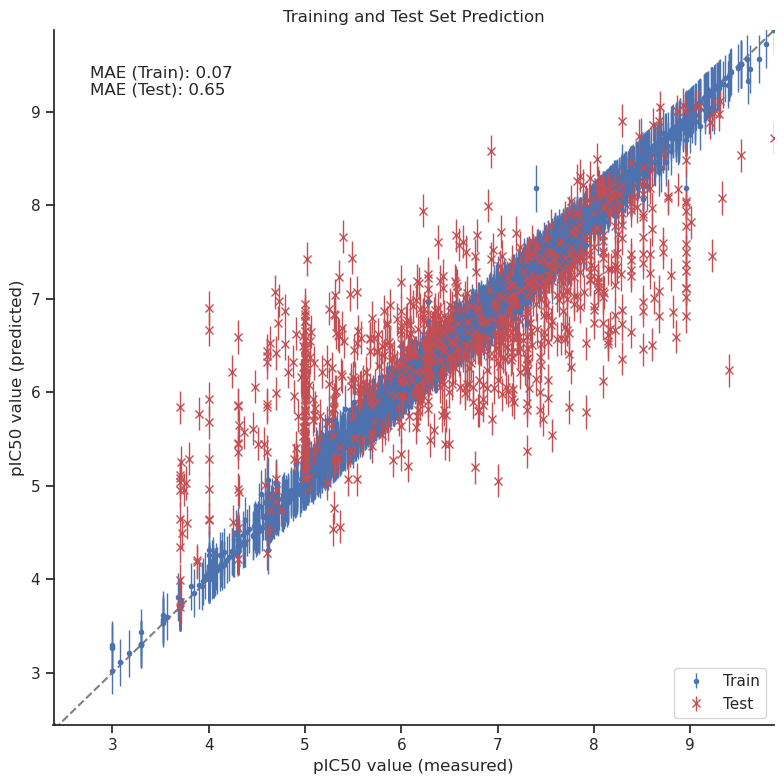

In [28]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xlim([np.min(y_train), np.max(y_train)])
    ax.set_ylim([np.min(y_train_predict), np.max(y_train_predict)])

    ax.errorbar(y_train, y_train_predict, fmt='.', label='Train', lw=1., capsize=0, yerr=0.2*y_train_predict.std())
    ax.errorbar(y_test, y_test_predict, fmt='x', color='r', markeredgewidth=1., label='Test', lw=1., capsize=0, yerr=0.2*y_test_predict.std())

    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')

    mae_train = mean_absolute_error(y_train, y_train_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)

    ax.set_title('Training and Test Set Prediction')
    ax.set_ylabel('pIC50 value (predicted)')
    ax.set_xlabel('pIC50 value (measured)')

    text = ('MAE (Train): {:.2f}'.format(mae_train) + '\n' +
            'MAE (Test): {:.2f}'.format(mae_test))

    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    ax.legend(loc='lower right')

    sns.despine()
    fig.tight_layout()
    
    fig.savefig('y_prediction.png', transparent=True)


Best estimator: {'bootstrap': False, 'feature_extractor': Kbest, 'k': 400, 'max_depth': 30, 'max_features': sqrt, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'preprocessor': Standard scaler, 'warm_startbool': false}

In [16]:
from sklearn.feature_selection import SelectKBest, chi2

from sklearnex import patch_sklearn
patch_sklearn() 

k_best = SelectKBest( k=400)
X_train_selected = k_best.fit_transform(x_train_scaled, y_train)
X_test_selected = k_best.transform(x_test_scaled)

regr = RandomForestRegressor(n_estimators = 100, 
                             max_depth = 30,
                             min_samples_split=2, 
                             min_samples_leaf= 1, 
                             warm_start = False, 
                             bootstrap = False,
                             max_features='sqrt',
                             n_jobs=-1)
regr.fit(X_train_selected, y_train)
y_train_predict= regr.predict(X_train_selected)
y_test_predict= regr.predict(X_test_selected)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  12   63   76  121  150  151  152  154  156  157  158  168  169  172
  179  186  187  191  193  200  202  220  231  233  258  373  402  535
  581  607  628  630  884  897  990 1013 1029 1044 1091 1105 1153 1221
 1273 1292 1331 1341 1541 1590 1594 1602 1748 1755 1765 1810 1916 1994
 2001 2147 2201 2225] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/mamba/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


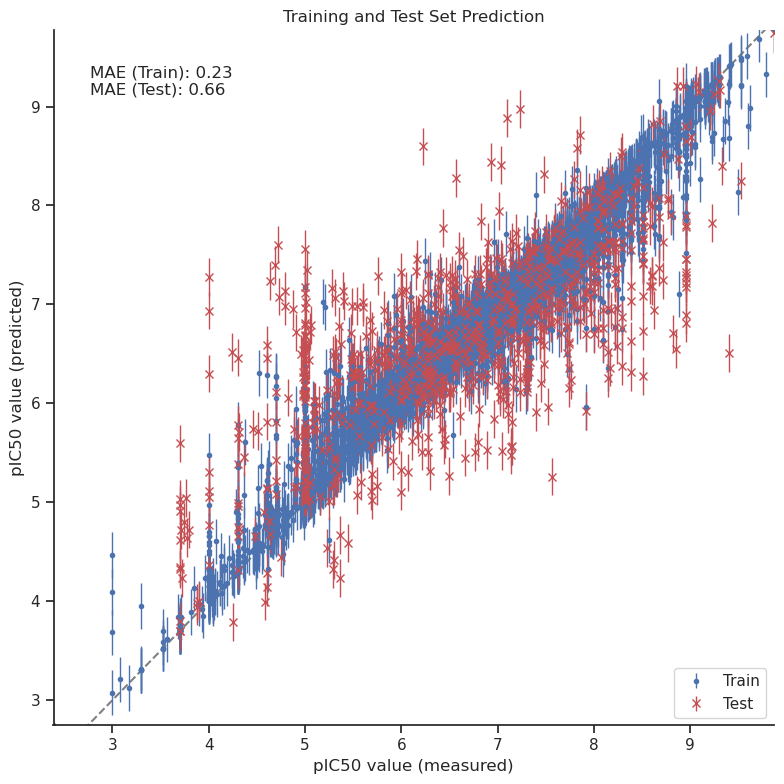

In [17]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xlim([np.min(y_train), np.max(y_train)])
    ax.set_ylim([np.min(y_train_predict), np.max(y_train_predict)])

    ax.errorbar(y_train, y_train_predict, fmt='.', label='Train', lw=1., capsize=0, yerr=0.2*y_train_predict.std())
    ax.errorbar(y_test, y_test_predict, fmt='x', color='r', markeredgewidth=1., label='Test', lw=1., capsize=0, yerr=0.2*y_test_predict.std())

    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')

    mae_train = mean_absolute_error(y_train, y_train_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)

    ax.set_title('Training and Test Set Prediction')
    ax.set_ylabel('pIC50 value (predicted)')
    ax.set_xlabel('pIC50 value (measured)')

    text = ('MAE (Train): {:.2f}'.format(mae_train) + '\n' +
            'MAE (Test): {:.2f}'.format(mae_test))

    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    ax.legend(loc='lower right')

    sns.despine()
    fig.tight_layout()
    
    fig.savefig('y_prediction.png', transparent=True)


In [15]:
len(y_test_predict)

3520